### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Inputs

In [2]:
inference_output_df = pd.read_csv("../outputs/inference_output.csv")
inference_output_confidence = inference_output_df['confidence'].values

In [3]:
fusion_output_df = pd.read_csv("../outputs/fusion_output.csv")
fusion_output_confidence = fusion_output_df['confidence'].values

In [4]:
kalman_output_df = pd.read_csv("../outputs/kalman_output.csv")
kalman_output_confidence = kalman_output_df['confidence'].values

### Comparação: GNN vs Fusão vs Kalman

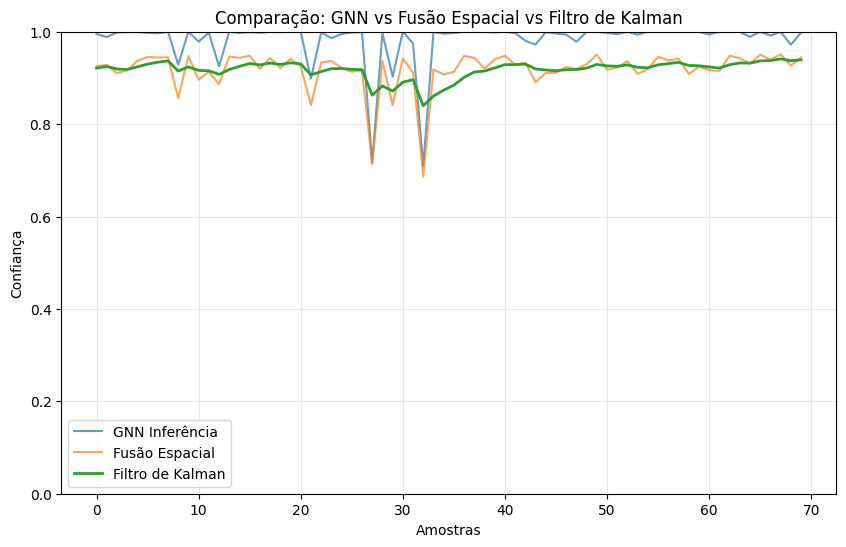

In [5]:
plt.figure(figsize=(10,6))

plt.plot(inference_output_confidence, label="GNN Inferência", alpha=0.7)
plt.plot(fusion_output_confidence, label="Fusão Espacial", alpha=0.7)
plt.plot(kalman_output_confidence, label="Filtro de Kalman", linewidth=2)

plt.title("Comparação: GNN vs Fusão Espacial vs Filtro de Kalman")
plt.xlabel("Amostras")
plt.ylabel("Confiança")

plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)

plt.show()

O gráfico mostra a comparação entre GNN, Fusão e Kalman em várias amostras.

- A GNN atinge valores altos de confiança, mas é bastante instável, caindo a zero em vários pontos.
- A Fusão apresenta resultados mais estáveis, geralmente entre 0.6 e 0.9, embora com quedas ocasionais.
- O Kalman é o mais regular, mantendo uma linha mais suave, mas com valores médios inferiores aos da GNN.

Assim, a GNN tem maior potencial, porém a Fusão e o Kalman oferecem mais consistência.

### Comparação: GNN vs Fusão vs Kalman (primeiras 10 amostras)

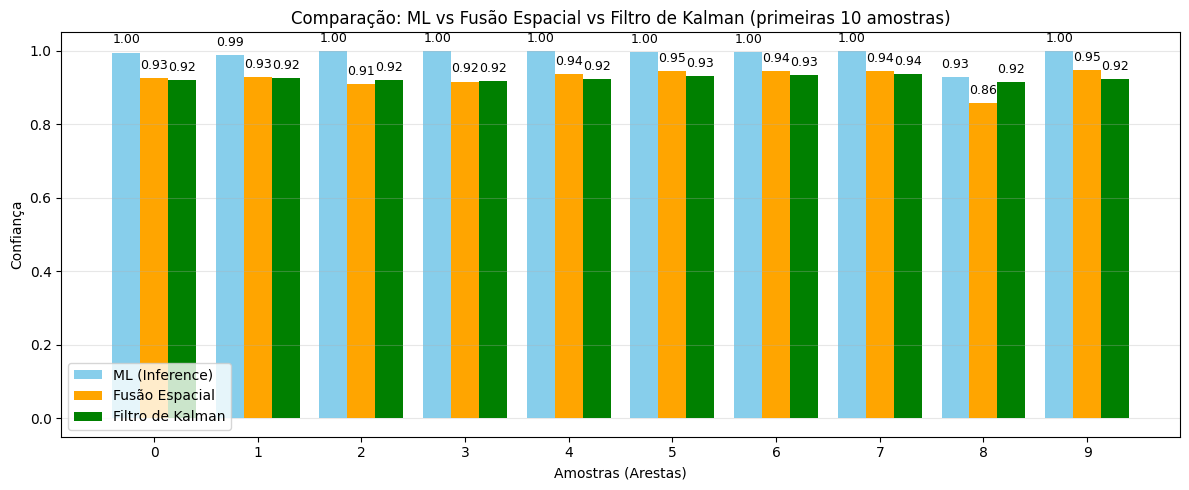

In [6]:
N = min(10, len(inference_output_confidence))
idx = np.arange(N)
ml_10  = np.array(inference_output_confidence[:N])
fus_10 = np.array(fusion_output_confidence[:N])
kal_10 = np.array(kalman_output_confidence[:N])

bar_w = 0.27
fig, ax = plt.subplots(figsize=(12, 5))
b1 = ax.bar(idx - bar_w, ml_10,  width=bar_w, label="ML (Inference)", color='skyblue')
b2 = ax.bar(idx,          fus_10, width=bar_w, label="Fusão Espacial", color='orange')
b3 = ax.bar(idx + bar_w,  kal_10, width=bar_w, label="Filtro de Kalman", color='green')

ymin = -0.05
ymax = 1.05           
ax.set_ylim(ymin, ymax)

ticks = np.linspace(0, 1, 6)  
ax.set_yticks(ticks)
ax.set_yticklabels([f"{t:.1f}" for t in ticks])

dy = 0.015 * (ymax - ymin)

def annotate_bars(bars, fmt="{:.2f}", delta=dy):
    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2., h + delta,
            fmt.format(h),
            ha="center", va="bottom", fontsize=9, clip_on=False
        )

annotate_bars(b1)
annotate_bars(b2)
annotate_bars(b3)

plt.title("Comparação: ML vs Fusão Espacial vs Filtro de Kalman (primeiras 10 amostras)")
plt.xlabel("Amostras (Arestas)")
plt.ylabel("Confiança")

plt.xticks(idx, [str(i) for i in idx])
plt.legend(loc="lower left")

plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()

plt.show()

O gráfico compara a confiança dos métodos GNN, Fusão e Kalman em 10 amostras.

- A GNN apresenta os melhores resultados na maioria dos casos, chegando a 1.0 em várias amostras, mostrando-se mais consistente e confiável.
- A Fusão mantém desempenho intermediário, mas cai bastante em algumas amostras (3 e 4).
- O Kalman é mais irregular: em certos pontos supera a Fusão, mas geralmente fica abaixo da GNN.

No geral, a GNN é o método mais robusto, enquanto Fusão e Kalman variam mais nos resultados.